In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t, f, norm

In [132]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV, SelectFromModel, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures

In [3]:
from scipy.optimize import brent, fsolve, fminbound

In [4]:
def prob(beta, data, intercept_included=False):
    if intercept_included==False:
        data = np.append(1, data)
    return 1/(1+np.exp(-(beta*data).sum()))

In [5]:
def llf(beta, data, label, intercept_included=False):
    value = 0
    for i in range(label.size):
        pi = prob(beta, data[i], intercept_included=intercept_included)
        value += label[i]*np.log(pi) + (1 - label[i])*np.log(1-pi)
    return -value

In [45]:
def llf(beta, data, label, intercept_included=False):
    target = np.array([-1 if i ==0 else 1 for i in label.values])
    value =sum( np.log(1/(1+np.exp(-(target*(data.dot(beta)))))) )
    return -value

# Load data

In [4]:
data = load_breast_cancer()
X, y, feature_names,  = data['data'], 1 - data['target'], data['feature_names']


In [189]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X, columns = feature_names), pd.Series(y, name='label'), test_size = .2, random_state=42)

In [249]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train: Logistic Regression

In [165]:
def irls(data, label, cost_cutoff, C=1.,max_iter = 100):
    b0_init = np.log(label.values.mean()/(1- label.values.mean()))
    w = np.array([b0_init]+[.0]*(data.shape[1]))
    x = np.hstack((np.ones((data.shape[0], 1)), data))
    mu = 1/(1+np.exp(-x.dot(w)))
    
    s = np.zeros((data.shape[0], data.shape[0]))
    np.fill_diagonal(s, [i*(1-i) for i in mu])
    cost = 0
    n_i = 0
    
    for n_iter in range(max_iter):
        w_0 = w
        w = np.linalg.inv( (x.T).dot(s.dot(x)) ).dot(x.T).dot( s.dot(x.dot(w)) + label.values - mu )
        c = C*llf(w, x, label) + w.dot(w)/2
        
        if n_iter==0:
            cost = c
            print(cost)
            n_i +=1
            mu = 1/(1+np.exp(-x.dot(w)))
            np.fill_diagonal(s, [i*(1-i) for i in mu])
        else:
            if (c>cost)|(c!=c)|(c<cost_cutoff):
                w = w_0
                print(cost, c)
                break
            else:
                cost = c
                n_i +=1
                print(cost)
                mu =1/(1+np.exp(-x.dot(w)))
                np.fill_diagonal(s, [i*(1-i) for i in mu])
    print(n_i)
    return w

In [191]:
beta0 = irls(X_train, y_train, cost_cutoff=.1,C=1.)

122.80797888601299
101.63656819086447
101.63656819086447 129.37129054490492
2


In [192]:
n_samp = 22

In [193]:
model = LogisticRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)

print(model.score(X_test, y_test))

0.9736842105263158


In [194]:
from scipy.stats import pearsonr
n_feat = X_train.shape[1]
ll = [np.exp((beta0[1:]*X_test[n_samp, :n_feat]).sum()  + beta0[0]) / (1+np.exp((beta0[1:]*X_test[n_samp, :n_feat]).sum()  + beta0[0])) for n_samp in range(X_test.shape[0])]
pearsonr(ll, pred_proba[:,1])

(0.9644632047191988, 1.4172010046049443e-66)

In [195]:
threshold = .5
ll1 = [1 if i >=threshold else 0 for i in ll]

In [196]:
sum(1 for i in np.array(ll1)==y_test.values if i==True)/y_test.size

0.9473684210526315

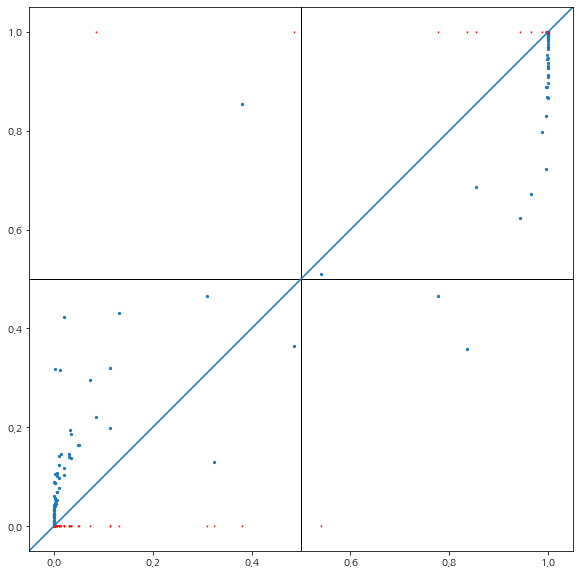

In [197]:

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)
ax.axline((.5,0), (.5,1), color='k', linewidth=1)
ax.axline((.0,.5), (.5,.5), color='k', linewidth=1)
ax.axline((0,0), (1,1))
ax.scatter(pred_proba[:,1], ll, s=5, marker = 'o')
ax.scatter(pred_proba[:,1], y_test.values, s=1, marker = 'v', color='r')
plt.show()

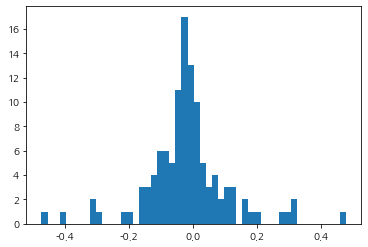

In [198]:
plt.hist(pred_proba[:,1] - ll, bins=50)
plt.show()

In [482]:
model = LogisticRegression(solver='lbfgs', )
n_feat = X_train.shape[1]
model.fit(X_train[:,0:n_feat], y_train)

pred = model.predict(X_test[:,0:n_feat])
pred_proba = model.predict_proba(X_test[:,0:n_feat])

print(model.score(X_test[:,0:n_feat], y_test))

0.9736842105263158


In [286]:
np.append(model.intercept_, model.coef_.flatten())

array([-0.83038453,  1.13449565,  1.33196438,  1.70486497,  1.39460431,
        1.62601918])

In [342]:
pred_proba[3]

array([0.89918048, 0.10081952])

In [272]:
def llf_neg(b_p, b_idx, data, label):
    beta = np.append(model.intercept_, model.coef_.flatten()[:1])
    beta[b_idx] = b_p
    return -llf(beta, data, label)

In [274]:
brent(llf_neg, args=(0, X_train[:, :1], y_train.values), brack=(-2,2))

-0.6437241565018229

In [32]:
lis = list(llf([1, i], X_train[:,0:1], y_train.values) for i in np.linspace(-7,7,  100))

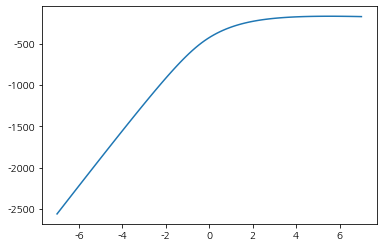

In [34]:
plt.plot(np.linspace(-7,7,  100), lis)

In [20]:
logit = (model.coef_[0]*X_train[0, 0:1]).sum() + model.intercept_[0]


In [24]:
1/(1+np.exp(-logit))

0.9518945843809761

In [27]:
X_train[0, 0:1]


array([1.0449852])

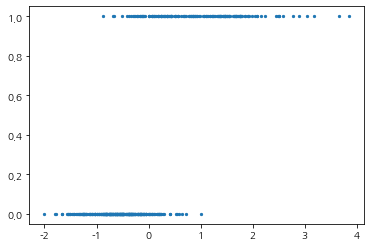

In [26]:
plt.scatter(X_train[:,:1], y_train, s=5)

In [34]:
model = LogisticRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)

print(model.score(X_test, y_test))

0.9736842105263158


In [40]:
logit = (model.coef_[0]*X_test[0]).sum() + model.intercept_[0]
np.e**(logit) / (1+np.e**(logit))

0.13757253297880911

In [41]:
pred_proba[0,1]

0.13757253297880903